In [1]:
%load_ext autoreload
%autoreload 2

from itertools import combinations
import numpy as np

from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import balanced_accuracy_score, root_mean_squared_error, confusion_matrix

from traffic.core import Traffic, Flight

In [2]:
datasets = [("unbalanced", True, True, True), ("unbalanced", True, True, False) ,("unbalanced", False, False, True),("balanced", False, False, True)]
run_type = 1
name, simple, classification, statistics = datasets[run_type]

In [4]:
train_name = f"{name}_train"
test_name = f"{name}_test"

flights_train, data_train, B_train = flights_from_query(None, train_name, load_results=True)
flights_test, data_test, B_test = flights_from_query(None, test_name, load_results=True)

pers_train = get_flight_persistances(flights_train, train_name, load_results=True)
LL_train, A_train, S_train, H_train = pers_train
pers_test = get_flight_persistances(flights_test, test_name, load_results=True)
LL_test, A_test, S_test, H_test = pers_test

y_train = data_train[:, 0]
y_test = data_test[:, 0]

if simple:
    y_train = (y_train != 1).astype(int)
    y_test = (y_test != 1).astype(int)

data = {
    'B': (B_train, B_test),
    'LL': (LL_train, LL_test),
    'A': (A_train, A_test),
    'S': (S_train, S_test),
    'H': (H_train, H_test),
    'y': (y_train, y_test)
}


C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:86: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")
C:\Users\tobso\Desktop\programering\masters-thesis\functions\gudhi_persistence_plotting.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


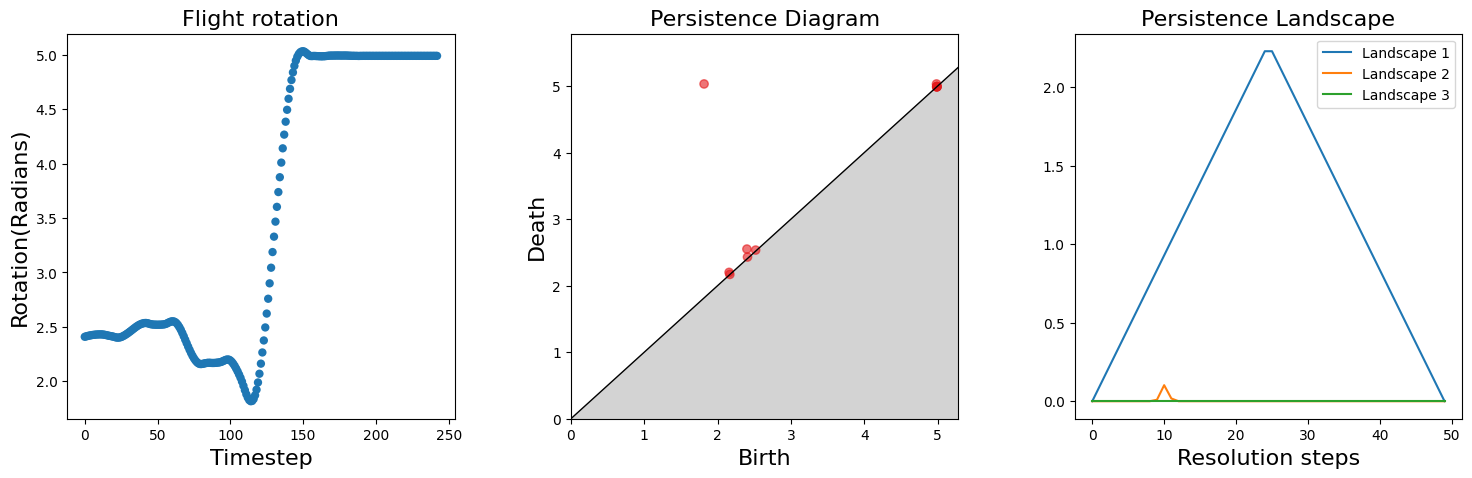

In [5]:
from gudhi.representations import Landscape

index = 200
dataset = 3

pers = pers_train[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=15, keep_endpoints=False)
pers.compute_landscapes()
None

In [6]:
def select_model(X, Y, seed, jobs=6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    trained_models = []
    scores = []

    for i in models.keys():
        model = GridSearchCV(
            models[i][0], 
            models[i][1],
            scoring="balanced_accuracy" if classification else "neg_root_mean_squared_error",
            cv=kfold,
            n_jobs=jobs
        )
        model.fit(X, Y)

        trained_models.append(model.best_estimator_)
        scores.append(model.best_score_)
    
    return trained_models, scores

In [7]:
def prepare_feature_combination(data_dict, feature_names):
    train_features = []
    test_features = []

    for feat_name in feature_names:
        train_feat, test_feat = data_dict[feat_name]
        if statistics:
            train_features.append(train_feat.stats if hasattr(train_feat, 'stats') else train_feat)
            test_features.append(test_feat.stats if hasattr(test_feat, 'stats') else test_feat)
        else:
            train_features.append(train_feat.landscapes if hasattr(train_feat, 'landscapes') else train_feat)
            test_features.append(test_feat.landscapes if hasattr(test_feat, 'landscapes') else test_feat)

    if len(feature_names) != 1:
        X_train = np.concatenate(train_features, axis=1)
        X_test = np.concatenate(test_features, axis=1)
    else:
        X_train = train_features[0]
        X_test = test_features[0]

    return X_train, X_test

In [8]:
feature_sets = ["B", "LL", "A", "S", "H"]
all_combinations = []

for r in range(1, len(feature_sets)+1):
    combinations_of_size_r = list(combinations(feature_sets, r))
    all_combinations.extend(combinations_of_size_r)

In [9]:
prepare_feature_combination(data, ["H"])[1].shape

(990, 45)

In [10]:
seed = 42

best_models = dict()
model_scores = dict()
pred_dict = dict()

for features in all_combinations:
    features_name = "+".join(features)

    X_train, X_test = prepare_feature_combination(data, features)
    y_train, y_test = prepare_feature_combination(data, ["y"])

    mask = np.logical_and(~np.any(np.isnan(X_train), axis=1), ~np.isnan(y_train))
    X_train = X_train[mask]
    y_train = y_train[mask]

    mask = np.logical_and(~np.any(np.isnan(X_test), axis=1), ~np.isnan(y_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    normalizer = preprocessing.StandardScaler()
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)

    models, scores = select_model(X_train, y_train, seed=seed, jobs=12)
    model_scores[features_name] = (models, scores)
    best_model = models[np.argmax(scores)]

    test_pred = best_model.predict(X_test)

    pred_dict[features_name] = (test_pred, y_test)

    if classification:
        final_score = balanced_accuracy_score(y_test, test_pred)
    else:
        final_score = root_mean_squared_error(y_test, test_pred)

    best_model_name = str(best_model).split("(")[0]
    best_models[features_name] = (best_model, best_model_name, final_score)
    print(f"{features_name} & {best_model_name} & {final_score:.3f}")

B & MLPClassifier & 0.996
LL & RandomForestClassifier & 0.951
A & RandomForestClassifier & 0.956
S & RandomForestClassifier & 0.967
H & SVC & 0.965
B+LL & SVC & 0.995
B+A & MLPClassifier & 0.994
B+S & SVC & 0.999
B+H & MLPClassifier & 0.996
LL+A & RandomForestClassifier & 0.973
LL+S & RandomForestClassifier & 0.978
LL+H & SVC & 0.963
A+S & RandomForestClassifier & 0.971
A+H & RandomForestClassifier & 0.978
S+H & SVC & 0.979
B+LL+A & MLPClassifier & 0.994
B+LL+S & MLPClassifier & 0.993
B+LL+H & MLPClassifier & 0.993
B+A+S & MLPClassifier & 0.995
B+A+H & MLPClassifier & 0.994
B+S+H & MLPClassifier & 0.995
LL+A+S & RandomForestClassifier & 0.983
LL+A+H & SVC & 0.981
LL+S+H & SVC & 0.979
A+S+H & RandomForestClassifier & 0.983
B+LL+A+S & MLPClassifier & 0.995
B+LL+A+H & MLPClassifier & 0.993
B+LL+S+H & SVC & 0.994
B+A+S+H & MLPClassifier & 0.992
LL+A+S+H & SVC & 0.984
B+LL+A+S+H & MLPClassifier & 0.998


In [11]:
for i, name in enumerate(model_scores["B"][0]):
    name = str(name).split("(")[0]
    mean = sum([score[1][i] for score in model_scores.values()])/len(model_scores)
    minimum = max([score[1][i] for score in model_scores.values()])
    maximum = min([score[1][i] for score in model_scores.values()])
    std = np.std([score[1][i] for score in model_scores.values()])
    print(f"{name} & {mean:.3f} & {minimum:.3f} & {maximum:.3f} & {std:.4f} \\\\")

DummyClassifier & 0.500 & 0.500 & 0.500 & 0.0000 \\
SVC & 0.982 & 0.995 & 0.930 & 0.0148 \\
MLPClassifier & 0.982 & 0.998 & 0.930 & 0.0161 \\
KNeighborsClassifier & 0.957 & 0.989 & 0.916 & 0.0179 \\
RandomForestClassifier & 0.982 & 0.995 & 0.934 & 0.0132 \\
DecisionTreeClassifier & 0.977 & 0.990 & 0.927 & 0.0149 \\


In [24]:
best_B_models = sorted(
    (i for i, (_, _, score) in best_models.items() if "B" in i),
    key=lambda i: best_models[i][2],
    reverse=classification
)

# Filter and sort models not containing "B"
best_non_B_models = sorted(
    (i for i, (_, _, score) in best_models.items() if "B" not in i),
    key=lambda i: best_models[i][2],
    reverse=classification
)

best_B_model = best_B_models[0]
best_non_B_model = best_non_B_models[0]

('B+S', 'LL+A+S+H')

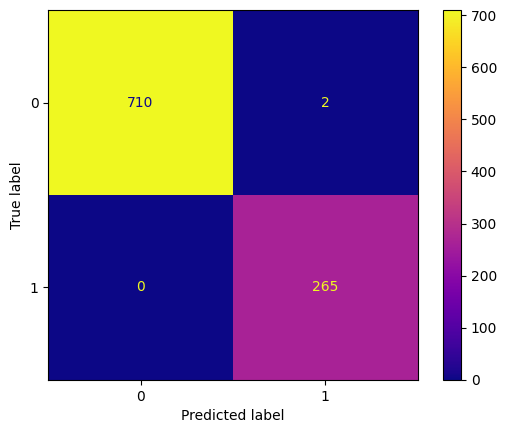

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_pred), cmap="plasma")

test_pred = pred_dict[best_B_model][0]
y_test = pred_dict[best_B_model][1]

if run_type == 0:
    test_pred = pred_dict[best_non_B_model][0]
    y_test = pred_dict[best_non_B_model][1]
    display.figure_.savefig("./Thesis Plots/Experiment2/binary_confusion_matrix_statistics.svg", format="svg", bbox_inches="tight")
elif run_type == 1:
    display.figure_.savefig("./Thesis Plots/Experiment2/binary_confusion_matrix_landscapes.svg", format="svg", bbox_inches="tight")
elif run_type == 2:
    display.figure_.savefig("./Thesis Plots/Experiment3/unbalanced_confusion_matrix.svg", format="svg", bbox_inches="tight")
elif run_type == 3:
    display.figure_.savefig("./Thesis Plots/Experiment3/balanced_confusion_matrix.svg", format="svg", bbox_inches="tight")

In [28]:
np.where(test_pred != y_test)

(array([214, 457], dtype=int64),)

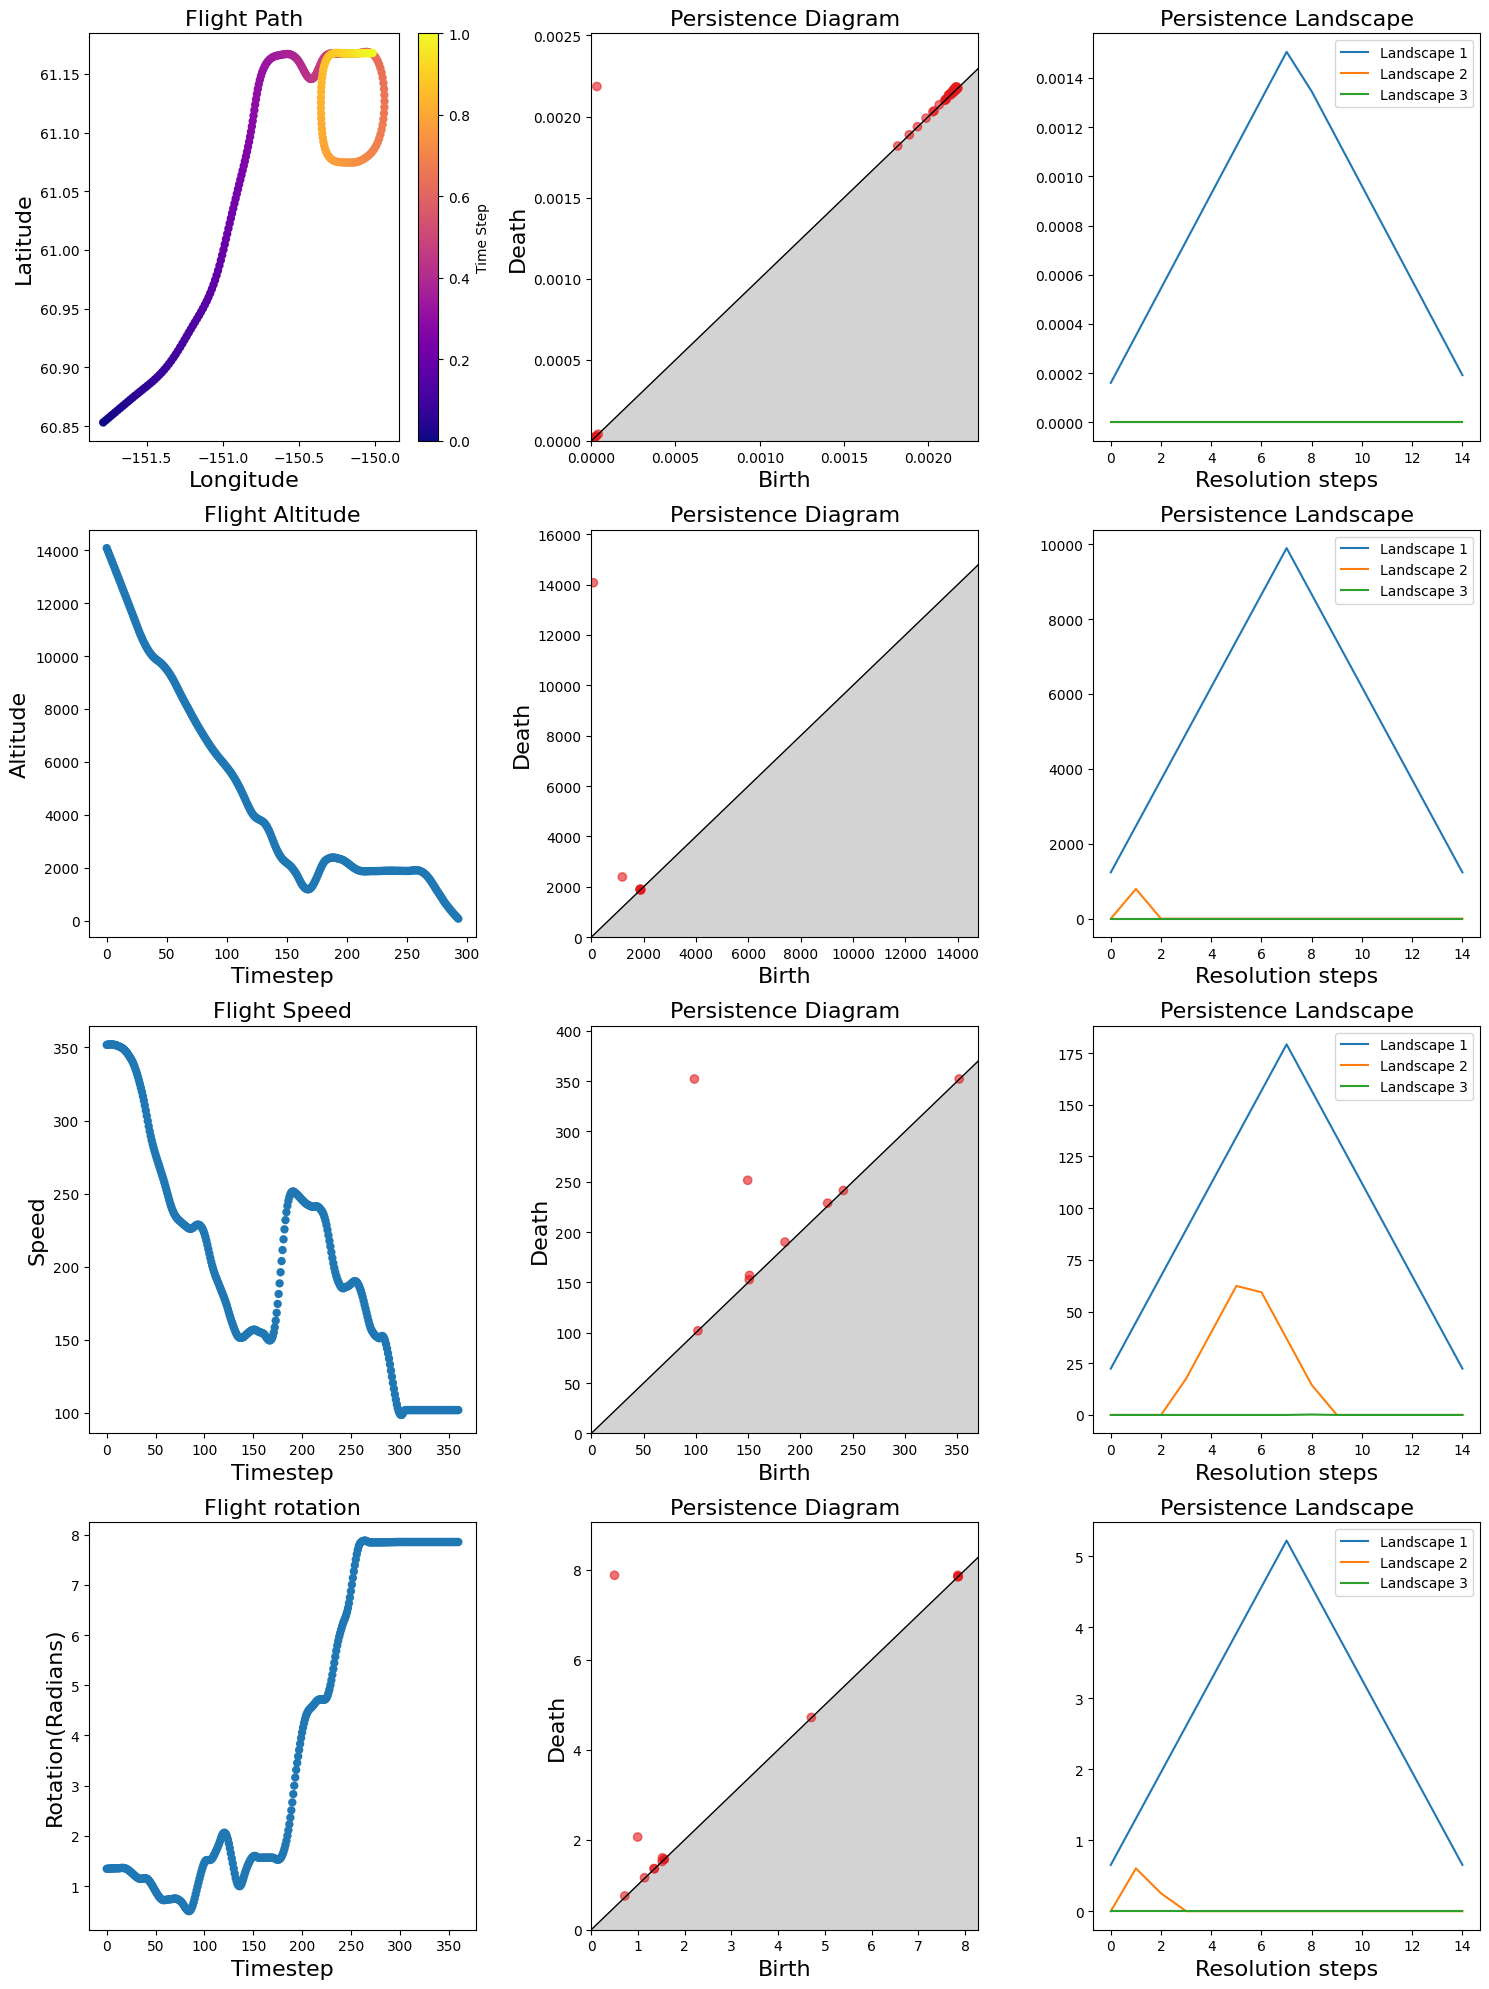

In [33]:
LL_data: PersistenceData = data["LL"][1]
A_data: PersistenceData = data["A"][1]
S_data: PersistenceData = data["S"][1]
H_data: PersistenceData = data["H"][1]
fig = PersistenceData.plot_multiple_diagrams([LL_data, A_data,S_data, H_data], 214, add_landscape=True)
fig.savefig("./Thesis plots/experiment2/landscape_false_negative1.svg", format="svg", bbox_inches="tight")

In [14]:
analysis_results = {}

for target_feature in feature_sets:
    with_scores = {}
    without_scores = {}

    for features_name, (_, _, score) in best_models.items():
        features = features_name.split("+")
        features_set = set(features)

        if target_feature in features_set:
            base_key = tuple(sorted(features_set - {target_feature}))
            with_scores[base_key] = score
        else:
            base_key = tuple(sorted(features_set))
            without_scores[base_key] = score

    diffs = []

    # Compare only if both versions exist
    for base_key in without_scores:
        if base_key in with_scores:
            diff = with_scores[base_key] - without_scores[base_key]
            diffs.append(diff)

    avg_without = sum(without_scores.values()) / len(without_scores) if without_scores else None
    avg_with = sum(with_scores.values()) / len(with_scores) if with_scores else None
    avg_diff = sum(diffs) / len(diffs) if diffs else None
    best_improvement = max(diffs) if diffs else None
    smallest_improvement = min(diffs) if diffs else None

    analysis_results[target_feature] = {
        "avg_without": avg_without,
        "avg_with": avg_with,
        "avg_diff": avg_diff,
        "max_change": best_improvement,
        "min_change": smallest_improvement,
    }
for features_name, info_dict in analysis_results.items():
    print(f"{features_name} & {' & '.join([f'{j:.4f}' for i, j in info_dict.items()])}")

B & 0.9727 & 0.9947 & 0.0219 & 0.0437 & 0.0089
LL & 0.9840 & 0.9841 & 0.0023 & 0.0174 & -0.0059
A & 0.9828 & 0.9852 & 0.0044 & 0.0222 & -0.0038
S & 0.9815 & 0.9864 & 0.0062 & 0.0268 & -0.0026
H & 0.9826 & 0.9854 & 0.0042 & 0.0225 & -0.0038


In [1]:
import pandas as pd

# Persistence landscapes data
landscapes_data = [
    ("B", 0.996), ("LL", 0.951), ("A", 0.956), ("S", 0.967), ("H", 0.965),
    ("B+LL", 0.995), ("B+A", 0.994), ("B+S", 0.999), ("B+H", 0.996),
    ("LL+A", 0.973), ("LL+S", 0.978), ("LL+H", 0.963), ("A+S", 0.971),
    ("A+H", 0.978), ("S+H", 0.979), ("B+LL+A", 0.994), ("B+LL+S", 0.993),
    ("B+LL+H", 0.993), ("B+A+S", 0.995), ("B+A+H", 0.994), ("B+S+H", 0.995),
    ("LL+A+S", 0.983), ("LL+A+H", 0.981), ("LL+S+H", 0.979), ("A+S+H", 0.983),
    ("B+LL+A+S", 0.995), ("B+LL+A+H", 0.993), ("B+LL+S+H", 0.994),
    ("B+A+S+H", 0.992), ("LL+A+S+H", 0.984), ("B+LL+A+S+H", 0.998)
]

# Persistence statistics data
statistics_data = [
    ("LL", 0.962), ("A", 0.984), ("S", 0.983), ("H", 0.981), ("LL+A", 0.980),
    ("LL+S", 0.988), ("LL+H", 0.986), ("A+S", 0.992), ("A+H", 0.997),
    ("S+H", 0.992), ("LL+A+S", 0.992), ("LL+A+H", 0.991), ("LL+S+H", 0.986),
    ("A+S+H", 0.995), ("LL+A+S+H", 0.995), ("B", 0.996), ("B+LL", 0.993),
    ("B+A", 0.996), ("B+S", 0.996), ("B+H", 0.995), ("B+LL+A", 0.994),
    ("B+LL+S", 0.993), ("B+LL+H", 0.993), ("B+A+S", 0.997), ("B+A+H", 0.996),
    ("B+S+H", 0.997), ("B+LL+A+S", 0.999), ("B+LL+A+H", 0.991),
    ("B+LL+S+H", 0.994), ("B+A+S+H", 1.000), ("B+LL+A+S+H", 0.995)
]

# Create DataFrames
df_landscapes = pd.DataFrame(landscapes_data, columns=["Feature-set combination", "Landscapes"])
df_statistics = pd.DataFrame(statistics_data, columns=["Feature-set combination", "Statistics"])

# Merge datasets on the feature-set combination
df = pd.merge(df_landscapes, df_statistics, on="Feature-set combination", how="inner")

# Calculate the difference
df["Difference"] =  df["Statistics"] - df["Landscapes"]

# Compute summary statistics
avg_landscapes = df["Landscapes"].mean()
avg_statistics = df["Statistics"].mean()
avg_difference = df["Difference"].mean()
max_change = df["Difference"].max()
min_change = df["Difference"].min()

# Print results
print(f"Average Landscapes: {avg_landscapes:.4f}")
print(f"Average Statistics: {avg_statistics:.4f}")
print(f"Average Difference (Landscapes - Statistics): {avg_difference:.4f}")
print(f"Max Change: {max_change:.4f}")
print(f"Min Change: {min_change:.4f}")

Average Landscapes: 0.9841
Average Statistics: 0.9913
Average Difference (Landscapes - Statistics): 0.0072
Max Change: 0.0280
Min Change: -0.0030


In [2]:
df["Statistics"] < df["Landscapes"]

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7      True
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26     True
27    False
28    False
29    False
30     True
dtype: bool